In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import copy
import matplotlib.pyplot as plt
import seaborn as sns

/Users/philhuang/opt/anaconda3/envs/py3k/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Part 1: Read in the data

In [2]:
# specify on the path
path= '/Users/philhuang/Desktop/Phil_projects/P5_PhilHuang/workingdata/'

# read in each sub-dataset
file_2020q1_OH=pd.read_csv(path+'file_2020Q1_OH.csv')
file_2020q1_VA=pd.read_csv(path+'file_2020Q1_VA.csv')
file_2020q1_GA=pd.read_csv(path+'file_2020Q1_GA.csv')
file_2020q1_MI=pd.read_csv(path+'file_2020Q1_MI.csv')
file_2020q1_CO=pd.read_csv(path+'file_2020Q1_CO.csv')

# concat all dataframes
df_all=pd.concat([file_2020q1_OH, file_2020q1_VA, file_2020q1_GA, file_2020q1_MI, file_2020q1_CO])

# check the data
print('Total number of obs:{0} \nNumber of unique loans:{1}'.format(len(df_all), df_all['LOAN_ID'].nunique()))

Total number of obs:2071611 
Number of unique loans:104924


In [3]:
df_all.groupby('STATE')['LOAN_ID'].count()

STATE
CO    485045
GA    428255
MI    479014
OH    339552
VA    339745
Name: LOAN_ID, dtype: int64

## Part 2: Define 'bad'
* We intend to apply a more stringent criterion for defining 'bad'.
* This definition bad will be used to build a payment default model.
* Two things to consider for defining such a variable as 'bad'?
** The definition should be representative of bad/derogatory behavior
** We can get enough such data points for modeling

In [4]:
df_all.columns.tolist()

['POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS',
 'REPUR

In [5]:
# define 'bad' loan to be loans with bucket six or more
df_all['bad']=np.where(df_all['DLQ_STATUS'] >= 6, 1, 0)
df_bad=df_all.groupby('LOAN_ID')['bad'].sum().reset_index()
df_bad['bad']=np.where(df_bad['bad'] > 0, 1, 0)

In [6]:
# check the df_bad dataset
print(df_bad['bad'].mean())
print(df_bad['bad'].sum())
df_bad.info()

0.02353131790629408
2469
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104924 entries, 0 to 104923
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   LOAN_ID  104924 non-null  int64
 1   bad      104924 non-null  int64
dtypes: int64(2)
memory usage: 1.6 MB


In [7]:
# merge the loan information with the 'bad' indicator
df_nodup=df_all.drop_duplicates(subset='LOAN_ID', keep='first').reset_index()
df_nodup=pd.merge(df_nodup.drop('bad', axis=1), df_bad, on='LOAN_ID', how='inner')
df_nodup['bad'].mean()

0.02353131790629408

### Part 3: Select variables for modeling
* Since this is an underwriting model, we will only select those variables available at the time of origination. 
* These varibles do not change their values throughout the life of a loan. 

In [8]:
# write a function to construct the dummy variables
def dummyvar(x):
    x['purpose_rate_refi']=np.where(x['PURPOSE'].str.strip()=='R', 1, 0)
    x['purpose_cashout_refi']=np.where(x['PURPOSE'].str.strip()=='C', 1, 0)
    x['property_pud']=np.where(x['PROP'].str.strip()=='PU', 1, 0)
    x['property_condo']=np.where(x['PROP'].str.strip()=='CO', 1, 0)
    x['property_other']=np.where(x['PROP'].str.strip().isin(['CP', 'MH']), 1, 0)
    x['term_30years']=np.where(x['ORIG_TERM']==360, 1, 0)
    x['term_15years']=np.where(x['ORIG_TERM']==180, 1, 0)
    x['mi']=np.where(x['MI_PCT'] > 0, 1, 0)
    
dummyvar(df_nodup)

In [9]:
columns_to_keep=['CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB', 'bad', 'LOAN_ID']

df_nodup[columns_to_keep].describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,104873.0,7.567624e+02,42.412137,620.0,729.00,766.0,791.00,835.0
DTI,104922.0,3.415779e+01,9.579630,1.0,27.00,35.0,42.00,50.0
OLTV,104924.0,7.392929e+01,16.254267,7.0,65.00,76.0,85.00,97.0
ORIG_UPB,104924.0,2.537213e+05,123826.341576,10000.0,156000.00,237000.0,335000.00,800000.0
bad,104924.0,2.353132e-02,0.151584,0.0,0.00,0.0,0.00,1.0
LOAN_ID,104924.0,9.917922e+07,197019.945107,98836742.0,99009455.75,99180553.5,99349026.75,99520476.0


In [10]:
# remove loans with no credit score or DTI
df_sample= copy.deepcopy(df_nodup[(df_nodup['CSCORE_B'] > 0) & (df_nodup['DTI'] > 0)][columns_to_keep])
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,104871.0,7.567624e+02,42.412282,620.0,729.0,766.0,791.0,835.0
DTI,104871.0,3.416106e+01,9.578838,1.0,27.0,35.0,42.0,50.0
OLTV,104871.0,7.392818e+01,16.254008,7.0,65.0,76.0,85.0,97.0
ORIG_UPB,104871.0,2.537530e+05,123823.523399,10000.0,156000.0,237000.0,335000.0,800000.0
bad,104871.0,2.354321e-02,0.151622,0.0,0.0,0.0,0.0,1.0
LOAN_ID,104871.0,9.917920e+07,197011.330265,98836742.0,99009454.5,99180544.0,99349004.0,99520476.0


### Part 4: Create additional features

* Split the sample into a modeling sample and a validation sample

In [11]:
# create a few more variables
df_sample['ORIG_UPB']        = np.log(df_sample['ORIG_UPB'])
df_sample['DTI_OTV']         = df_sample['DTI']/df_sample['OLTV']
df_sample['home_price']      = df_sample['ORIG_UPB']/df_sample['OLTV']
df_sample['home_price_log']  = np.log(df_sample['home_price'])
df_sample['home_price_fico'] = df_sample['CSCORE_B']/df_sample['home_price_log']

In [12]:
# construct feature matrix and the response variable
x = df_sample.drop('bad', axis=1)
y = df_sample['bad']

In [13]:
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,104871.0,7.567624e+02,42.412282,6.200000e+02,7.290000e+02,7.660000e+02,7.910000e+02,8.350000e+02
DTI,104871.0,3.416106e+01,9.578838,1.000000e+00,2.700000e+01,3.500000e+01,4.200000e+01,5.000000e+01
OLTV,104871.0,7.392818e+01,16.254008,7.000000e+00,6.500000e+01,7.600000e+01,8.500000e+01,9.700000e+01
ORIG_UPB,104871.0,1.231152e+01,0.542656,9.210340e+00,1.195761e+01,1.237582e+01,1.272189e+01,1.359237e+01
bad,104871.0,2.354321e-02,0.151622,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
LOAN_ID,104871.0,9.917920e+07,197011.330265,9.883674e+07,9.900945e+07,9.918054e+07,9.934900e+07,9.952048e+07
DTI_OTV,104871.0,4.909012e-01,0.216396,1.428571e-02,3.604651e-01,4.625000e-01,5.733333e-01,6.000000e+00
home_price,104871.0,1.784673e-01,0.062403,1.004928e-01,1.448736e-01,1.619981e-01,1.905702e-01,1.644704e+00
home_price_log,104871.0,-1.762896e+00,0.259041,-2.297670e+00,-1.931894e+00,-1.820171e+00,-1.657734e+00,4.975602e-01
home_price_fico,104871.0,-4.479487e+02,685.871179,-1.316447e+05,-4.610079e+02,-4.192927e+02,-3.870479e+02,5.644541e+04


In [14]:
x.shape, y.shape

((104871, 9), (104871,))

In [15]:
# split the sample into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=0)

In [16]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

# check the shape
x_train.shape, x_test.shape

((73409, 9), (31462, 9))

In [17]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test  = sc.transform(x_test)
x_train.shape, x_test.shape

((73409, 9), (31462, 9))

In [18]:
# reshape the dataset
# You must add a 3rd dimension in order to run neural network
x_train = x_train.reshape(73409, 9, 1)
x_test  = x_test.reshape(31462, 9, 1)
x_train.shape, x_test.shape

((73409, 9, 1), (31462, 9, 1))

### Part 5: Artificial Neural Network (ANN)
#### 5.1: set up the ANN model structure

In [19]:
import tensorflow as tf
print(tf.__version__)

model=tf.keras.models.Sequential()

# set up initial input layer
# input_dim should be the same as number of input variables
model.add(tf.keras.layers.Dense(units=9, activation='relu', input_dim=9))

# add 2nd hidden layer
model.add(tf.keras.layers.Dense(units=6, activation='relu'))

# output layer
# units should be the same as the predicted goal. In our case, we are predicting bad, so units=1.
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2023-08-16 11:00:45.196055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 6)                 60        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 157 (628.00 Byte)
Trainable params: 157 (628.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 5.2: Run ANN model

In [20]:
# Epoch is the number of iterations
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
7341/7341 [==============================] - 8s 1ms/step - loss: 0.1173 - accuracy: 0.9743
Epoch 2/10
7341/7341 [==============================] - 7s 1ms/step - loss: 0.1052 - accuracy: 0.9764
Epoch 3/10
7341/7341 [==============================] - 7s 1ms/step - loss: 0.1046 - accuracy: 0.9764
Epoch 4/10
7341/7341 [==============================] - 7s 1ms/step - loss: 0.1044 - accuracy: 0.9764
Epoch 5/10
7341/7341 [==============================] - 7s 1ms/step - loss: 0.1043 - accuracy: 0.9764
Epoch 6/10
7341/7341 [==============================] - 7s 1ms/step - loss: 0.1042 - accuracy: 0.9764
Epoch 7/10
7341/7341 [==============================] - 8s 1ms/step - loss: 0.1041 - accuracy: 0.9764
Epoch 8/10
7341/7341 [==============================] - 7s 1ms/step - loss: 0.1042 - accuracy: 0.9764
Epoch 9/10
7341/7341 [==============================] - 7s 1ms/step - loss: 0.1041 - accuracy: 0.9764
Epoch 10/10
7341/7341 [==============================] - 8s 1ms/step - loss: 0.103

In [21]:
# evaluate the model
test_loss, test_acc=model.evaluate(x_test, y_test)

984/984 [==============================] - 1s 833us/step - loss: 0.1020 - accuracy: 0.9767


In [22]:
print("Test Accuracy: {}".format(test_acc))

Test Accuracy: 0.9766702651977539


In [23]:
# The following only works for tensorflow 2.6 or later.
# make predictions
y_pred    = model.predict(x_test)
classes_y = np.argmax(y_pred, axis=1)

984/984 [==============================] - 1s 747us/step


In [24]:
# check the data
y_pred_df=pd.DataFrame(y_pred)
y_pred_df.columns=['y_pred']
y_pred_df

,y_pred
0,0.023873
1,0.019992
2,0.056283
3,0.007062
4,0.068778
...,...
31457,0.037023
31458,0.014700
31459,0.055647
31460,0.011905


In [25]:
y_test_df=pd.DataFrame(y_test)
y_test_df.columns=['y']
y_test_df['y_pred']=y_pred_df

In [26]:
num_bins=10

binlabels=list(range(0, num_bins))

y_test_df['score_cut']=pd.qcut(y_test_df['y_pred'], q=num_bins, labels=binlabels)

y_test_df

,y,y_pred,score_cut
0,0,0.023873,7
1,0,0.019992,6
2,0,0.056283,9
3,0,0.007062,3
4,0,0.068778,9
...,...,...,...
31457,0,0.037023,8
31458,0,0.014700,5
31459,0,0.055647,9
31460,0,0.011905,4


In [27]:
# make a copy of the scoring result to a comparison with CNN model later
y_test_df_ann = copy.deepcopy(y_test_df)

<AxesSubplot: xlabel='score_cut', ylabel='y'>

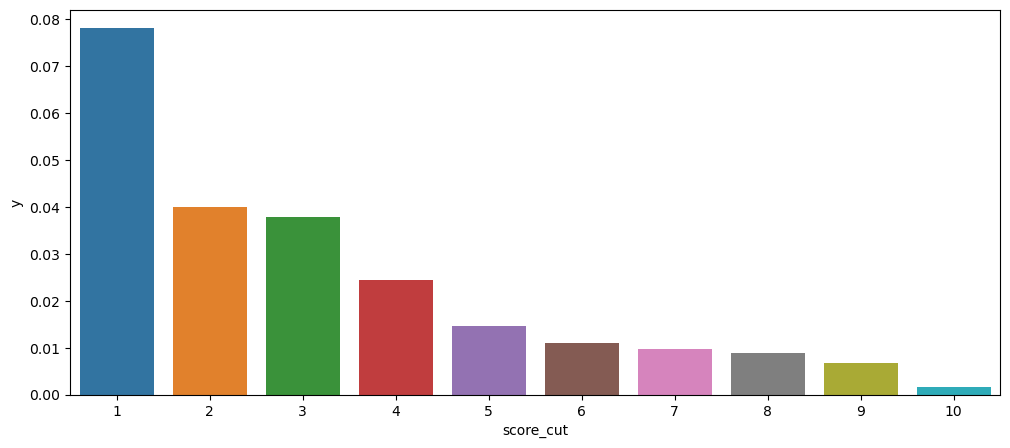

In [28]:
fig=plt.figure(figsize=(12, 5))

y_test_df_sum=y_test_df.groupby('score_cut')[['y_pred', 'y']].mean().reset_index()
y_test_df_sum['score_cut']=y_test_df_sum['score_cut'].astype(int)
y_test_df_sum['score_cut']=num_bins-y_test_df_sum['score_cut']

sns.barplot(data =y_test_df_sum, 
            x=y_test_df_sum['score_cut'], 
            y=y_test_df_sum['y'])

Text(0, 0.5, 'Predicted/Actual')

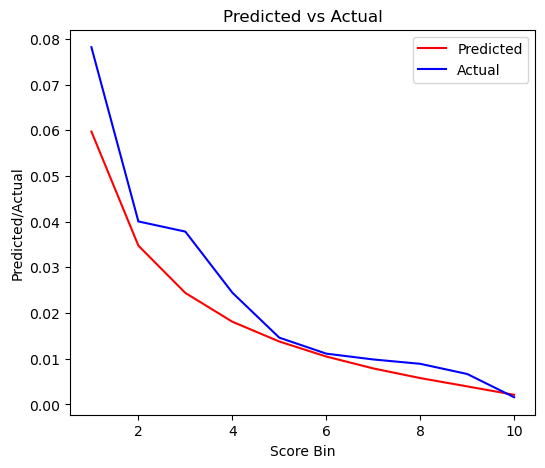

In [29]:
fig, ax=plt.subplots(1, 1, figsize=(6, 5))

ax.plot(y_test_df_sum['score_cut'], y_test_df_sum['y_pred'], label='Predicted', color='red')
ax.plot(y_test_df_sum['score_cut'], y_test_df_sum['y'], label='Actual', color='blue')
ax.set_title('Predicted vs Actual')
ax.legend(loc='upper right')
ax.set_xlabel('Score Bin')
ax.set_ylabel('Predicted/Actual')

### Part 6: Convoluted Neural Network (CNN)
#### 6.1: Set up the CNN model structure

In [30]:
# define an object for the model
model=tf.keras.models.Sequential()

In [31]:
# 1st CNN layer
# input shape should correpond to number of input variables
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(9, 1)))

# batch normalization 
model.add(tf.keras.layers.BatchNormalization())

# maxpool layer
model.add(tf.keras.layers.MaxPool1D(pool_size=2))

# dropout layer
# This layer deliberately exclude some data so that the model will not overfit
# Usually select 0.2-0.5 as the dropout rate
model.add(tf.keras.layers.Dropout(0.2))

# 2nd CNN layer
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))

# batch normalization 
model.add(tf.keras.layers.BatchNormalization())

# maxpool layer
model.add(tf.keras.layers.MaxPool1D(pool_size=2))

# dropout layer
model.add(tf.keras.layers.Dropout(0.3))

In [32]:
# flatten layer
model.add(tf.keras.layers.Flatten())

In [33]:
# first dense layer
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# dropout layer
model.add(tf.keras.layers.Dropout(0.3))

In [34]:
# output layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 32)             96        
                                                                 
 batch_normalization (Batch  (None, 9, 32)             128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 64)             4160      
                                                                 
 batch_normalization_1 (Bat  (None, 4, 64)            

In [36]:
# learning rate is one of hyperparameters
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [37]:
# compile the CNN model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#### 6.2: Run CNN model

In [38]:
history=model.fit(x_train, y_train, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
2295/2295 [==============================] - 7s 3ms/step - loss: 0.1907 - accuracy: 0.9495 - val_loss: 0.1216 - val_accuracy: 0.9767
Epoch 2/25
2295/2295 [==============================] - 6s 2ms/step - loss: 0.1296 - accuracy: 0.9759 - val_loss: 0.1077 - val_accuracy: 0.9767
Epoch 3/25
2295/2295 [==============================] - 6s 2ms/step - loss: 0.1211 - accuracy: 0.9763 - val_loss: 0.1280 - val_accuracy: 0.9767
Epoch 4/25
2295/2295 [==============================] - 6s 2ms/step - loss: 0.1167 - accuracy: 0.9763 - val_loss: 0.1059 - val_accuracy: 0.9767
Epoch 5/25
2295/2295 [==============================] - 6s 2ms/step - loss: 0.1150 - accuracy: 0.9764 - val_loss: 0.1069 - val_accuracy: 0.9767
Epoch 6/25
2295/2295 [==============================] - 6s 2ms/step - loss: 0.1134 - accuracy: 0.9764 - val_loss: 0.1074 - val_accuracy: 0.9767
Epoch 7/25
2295/2295 [==============================] - 6s 2ms/step - loss: 0.1120 - accuracy: 0.9764 - val_loss: 0.1095 - val_accuracy:

In [39]:
# model predictions
y_pred=model.predict(x_test)
classes_y=np.argmax(y_pred, axis=1)

984/984 [==============================] - 1s 981us/step


In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm=confusion_matrix(y_test, classes_y)
print(cm)

[[30728     0]
 [  734     0]]


In [41]:
acc_cm=accuracy_score(y_test, classes_y)
print(acc_cm)

0.9766702688958108


In [44]:
# Learning curve
def learning_curve(history, epoch):
    # training vs validation accuracy
    epoch_range=range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    

    # training vs validation loss
    epoch_range=range(1, epoch+1)
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('LOss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

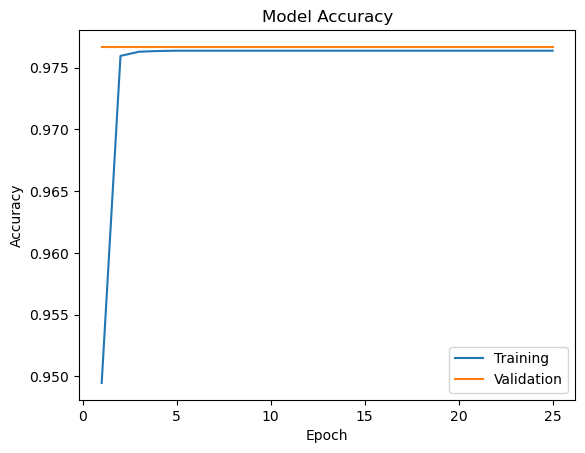

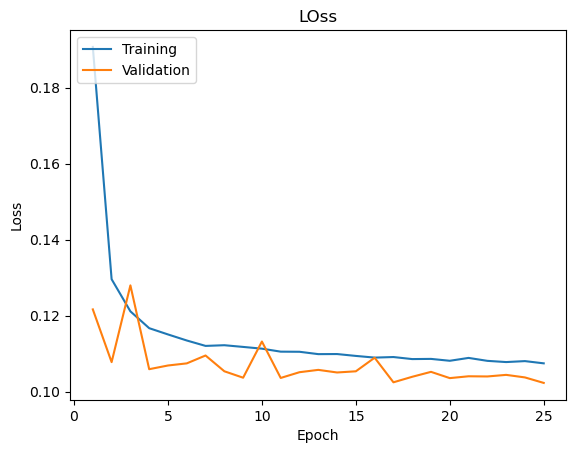

In [45]:
learning_curve(history, 25)

In [46]:
y_pred_df=pd.DataFrame(y_pred)
y_pred_df.columns=['y_pred']

In [47]:
y_test_df=pd.DataFrame(y_test)
y_test_df.columns=['y']

In [48]:
y_test_df['y_pred']=y_pred_df

In [49]:
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31462 entries, 0 to 31461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       31462 non-null  int64  
 1   y_pred  31462 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 368.8 KB


In [50]:
num_bins=10

binlabels=list(range(0, num_bins))

y_test_df['score_cut']=pd.qcut(y_test_df['y_pred'], q=num_bins, labels=binlabels)

<AxesSubplot: xlabel='score_cut', ylabel='y'>

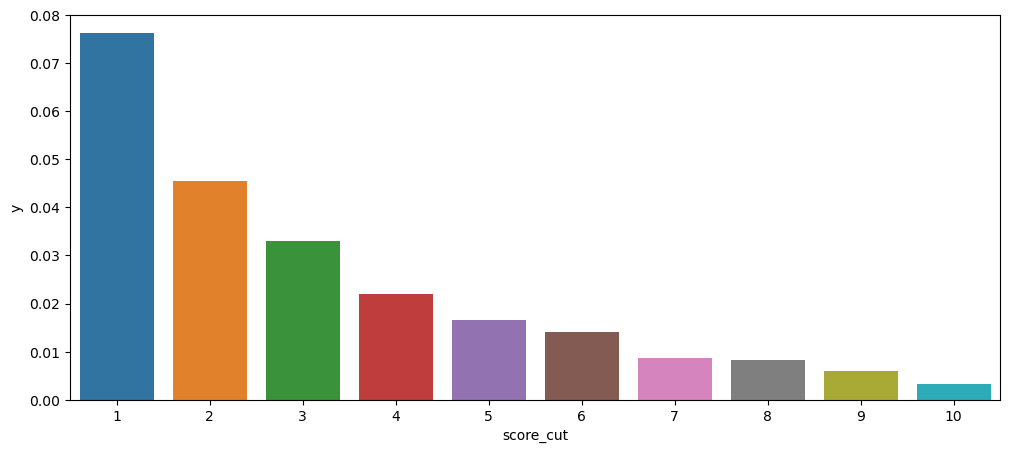

In [51]:
fig=plt.figure(figsize=(12, 5))

y_test_df_sum=y_test_df.groupby('score_cut')[['y_pred', 'y']].mean().reset_index()
y_test_df_sum['score_cut']=y_test_df_sum['score_cut'].astype(int)
y_test_df_sum['score_cut']=num_bins-y_test_df_sum['score_cut']

sns.barplot(x=y_test_df_sum['score_cut'], y=y_test_df_sum['y'])

Text(0, 0.5, 'Predicted/Actual')

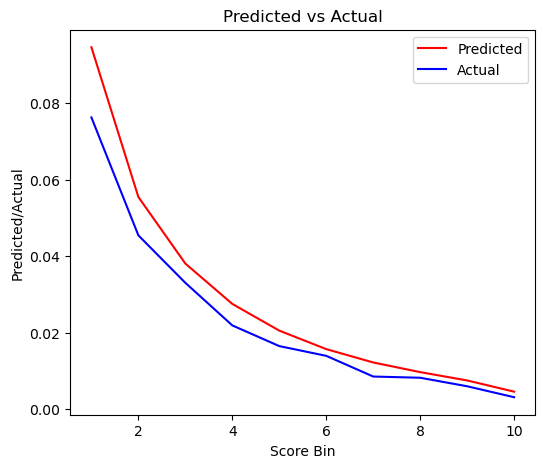

In [52]:
fig, ax=plt.subplots(1, 1, figsize=(6, 5))

ax.plot(y_test_df_sum['score_cut'], y_test_df_sum['y_pred'], label='Predicted', color='red')
ax.plot(y_test_df_sum['score_cut'], y_test_df_sum['y'], label='Actual', color='blue')
ax.set_title('Predicted vs Actual')
ax.legend(loc='upper right')
ax.set_xlabel('Score Bin')
ax.set_ylabel('Predicted/Actual')

In [53]:
y_test_df_cnn = copy.deepcopy(y_test_df)

### Part 7: combine two models

In [54]:
y_test_df_cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31462 entries, 0 to 31461
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   y          31462 non-null  int64   
 1   y_pred     31462 non-null  float32 
 2   score_cut  31462 non-null  category
dtypes: category(1), float32(1), int64(1)
memory usage: 399.9 KB


In [55]:
y_test_df_ann.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31462 entries, 0 to 31461
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   y          31462 non-null  int64   
 1   y_pred     31462 non-null  float32 
 2   score_cut  31462 non-null  category
dtypes: category(1), float32(1), int64(1)
memory usage: 399.9 KB


In [56]:
y_test_combined=pd.concat([y_test_df_ann.rename(columns={'y':'y_ann', 'y_pred': 'y_pred_ann', 'score_cut':'score_cut_ann'}),
                          y_test_df_cnn.rename(columns={'y':'y_cnn', 'y_pred': 'y_pred_cnn', 'score_cut':'score_cut_cnn'})],
                         axis=1)

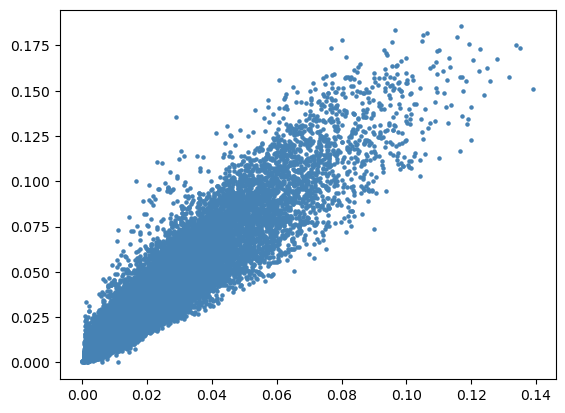

In [65]:
plt.scatter(y_test_combined['y_pred_ann'], y_test_combined['y_pred_cnn'], color='steelblue', s=5)

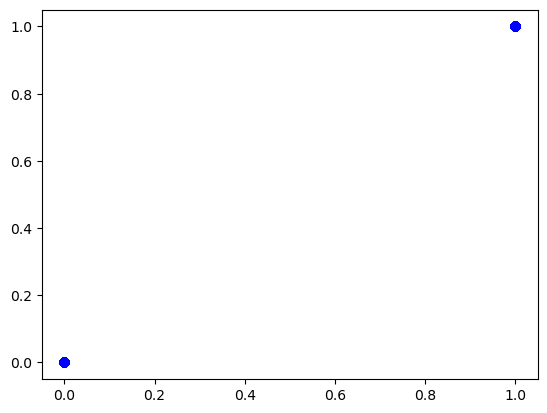

In [66]:
# check consistency of the order of y in both ANN sample and CNN sample
plt.plot(y_test_combined['y_ann'], y_test_combined['y_cnn'], 'o', color='blue')

In [68]:
np.corrcoef(y_test_combined['y_pred_ann'], y_test_combined['y_pred_cnn'])

array([[1.       , 0.9369516],
       [0.9369516, 1.       ]])

In [69]:
two_cuts_bad=y_test_combined.pivot_table(index='score_cut_ann', columns='score_cut_cnn', values='y_ann', 
                                     aggfunc='mean', dropna=False)
two_cuts_bad

score_cut_cnn,0,1,2,3,4,5,6,7,8,9
score_cut_ann,,,,,,,,,,
0,0.001554,0.001637,0.003322,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,0.006682,0.008772,0.006380,0.002985,0.000000,0.014286,0.000000,NaN,NaN,NaN
2,0.003663,0.003286,0.012746,0.014286,0.014652,0.000000,0.000000,0.000000,0.000000,NaN
3,0.000000,0.011038,0.007177,0.008464,0.015762,0.000000,0.026786,0.047619,0.000000,NaN
4,0.000000,0.007874,0.009346,0.009138,0.011521,0.016807,0.003425,0.035714,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.008219,0.014960,0.017131,0.012966,0.026316,0.000000,0.000000
6,NaN,0.000000,0.000000,0.000000,0.022876,0.020157,0.027803,0.026194,0.021127,0.076923
7,NaN,NaN,NaN,NaN,0.142857,0.035533,0.023058,0.039540,0.053492,0.018519
8,NaN,NaN,NaN,NaN,NaN,0.000000,0.054688,0.029101,0.038275,0.055285


In [70]:
two_cuts_count=y_test_combined.pivot_table(index='score_cut_ann', columns='score_cut_cnn', values='y_ann', 
                                     aggfunc='count', dropna=False)
two_cuts_count

score_cut_cnn,0,1,2,3,4,5,6,7,8,9
score_cut_ann,,,,,,,,,,
0,1930,611,301,198,71,28,7,1,0,0
1,898,1026,627,335,181,70,9,0,0,0
2,273,913,863,630,273,144,42,7,1,0
3,41,453,836,827,571,284,112,21,1,0
4,4,127,428,766,868,595,292,56,9,1
5,1,15,89,365,869,934,617,228,26,2
6,0,1,2,25,306,893,1115,649,142,13
7,0,0,0,0,7,197,824,1391,673,54
8,0,0,0,0,0,1,128,756,1646,615


Text(95.72222222222221, 0.5, 'CNN Score')

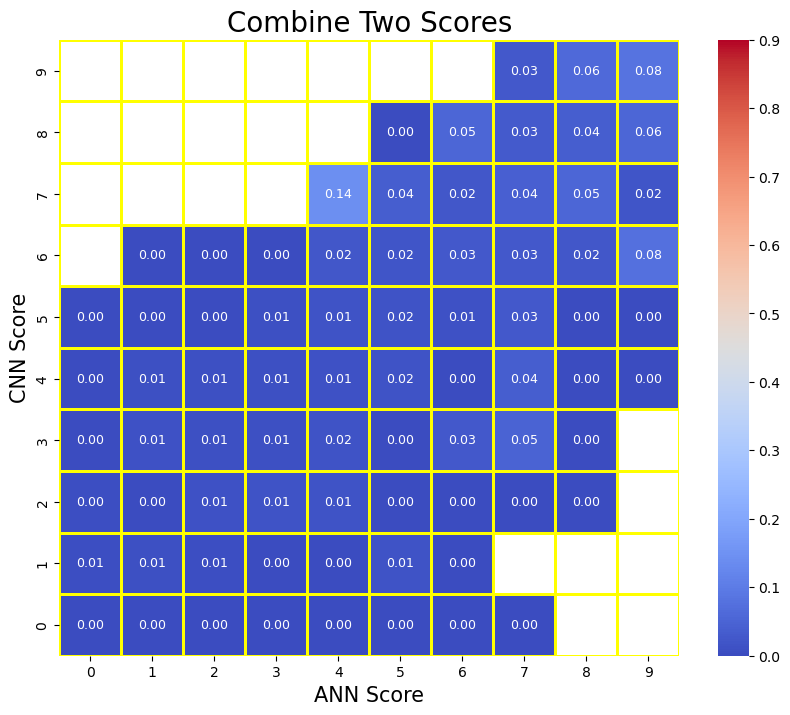

In [71]:
fig=plt.figure(figsize=(10, 8))
ax=plt.axes()
sns.heatmap(two_cuts_bad, cmap='coolwarm', fmt=".2f", vmin=0, vmax=0.9, linewidths=2, linecolor='yellow',
            annot=True, annot_kws={"size": 9}).invert_yaxis()
ax.set_title("Combine Two Scores", fontsize=20)
ax.set_xlabel('ANN Score', fontsize=15)
ax.set_ylabel('CNN Score', fontsize=15)

Text(95.72222222222221, 0.5, 'CNN Score')

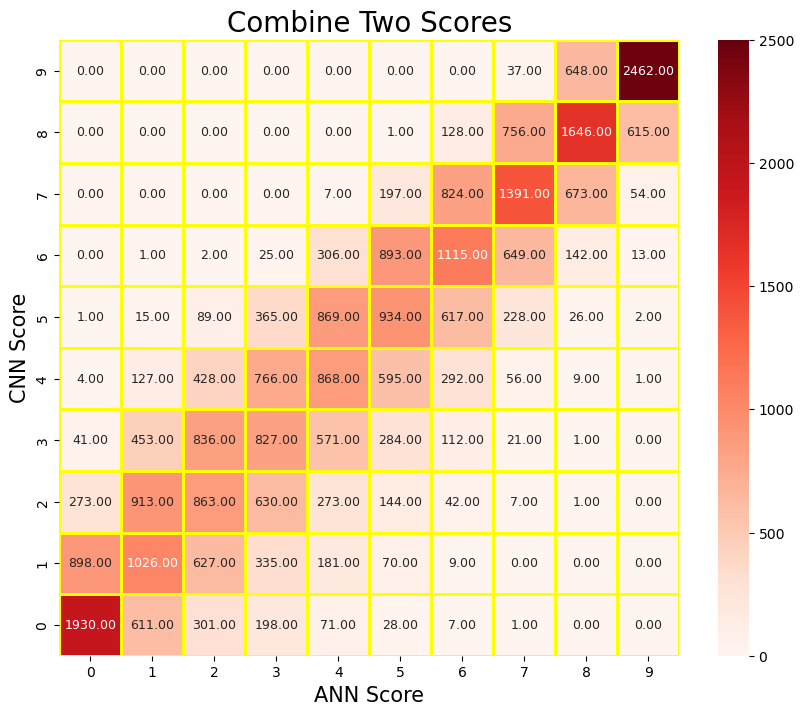

In [74]:
fig=plt.figure(figsize=(10, 8))
ax=plt.axes()
sns.heatmap(two_cuts_count, cmap='Reds', fmt=".2f", vmin=0, vmax=2500, linewidths=2, linecolor='yellow',
            annot=True, annot_kws={"size": 9}).invert_yaxis()
ax.set_title("Combine Two Scores", fontsize=20)
ax.set_xlabel('ANN Score', fontsize=15)
ax.set_ylabel('CNN Score', fontsize=15)

#### composite score - approach 1

In [75]:
y_test_combined['composite_score']=np.sqrt(y_test_combined['y_pred_ann']*y_test_combined['y_pred_cnn'])

<AxesSubplot: xlabel='score_cut', ylabel='y_ann'>

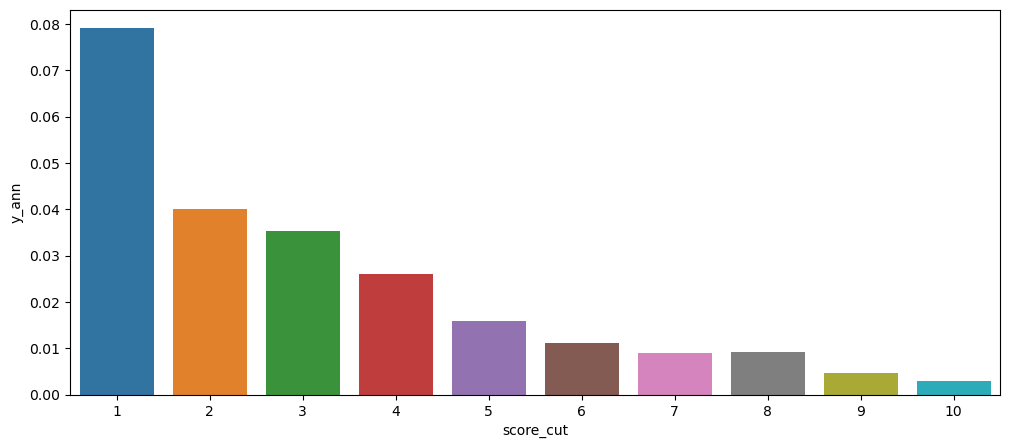

In [76]:
num_bins=10

binlabels=list(range(0, num_bins))

y_test_combined['score_cut']=pd.qcut(y_test_combined['composite_score'], q=num_bins, labels=binlabels)

fig=plt.figure(figsize=(12, 5))

y_test_combined=y_test_combined.groupby('score_cut')[['composite_score', 'y_ann']].mean().reset_index()
y_test_combined['score_cut']=y_test_combined['score_cut'].astype(int)
y_test_combined['score_cut']=num_bins-y_test_combined['score_cut']

sns.barplot(x=y_test_combined['score_cut'], y=y_test_combined['y_ann'])

Text(0, 0.5, 'Predicted/Actual')

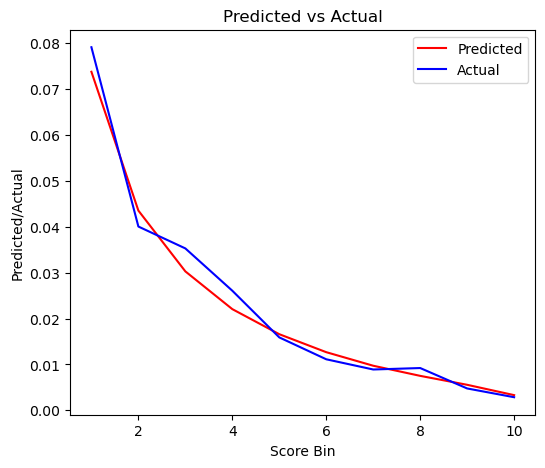

In [77]:
fig, ax=plt.subplots(1, 1, figsize=(6, 5))

ax.plot(y_test_combined['score_cut'], y_test_combined['composite_score'], label='Predicted', color='red')
ax.plot(y_test_combined['score_cut'], y_test_combined['y_ann'], label='Actual', color='blue')
ax.set_title('Predicted vs Actual')
ax.legend(loc='upper right')
ax.set_xlabel('Score Bin')
ax.set_ylabel('Predicted/Actual')

#### composite score - approach 2

In [78]:
y_test_combined=pd.concat([y_test_df_ann.rename(columns={'y':'y_ann', 'y_pred': 'y_pred_ann', 'score_cut':'score_cut_ann'}),
                          y_test_df_cnn.rename(columns={'y':'y_cnn', 'y_pred': 'y_pred_cnn', 'score_cut':'score_cut_cnn'})],
                         axis=1)

y_test_combined['composite_score']=(y_test_combined['y_pred_ann']+y_test_combined['y_pred_cnn'])/2

In [79]:
y_test_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31462 entries, 0 to 31461
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   y_ann            31462 non-null  int64   
 1   y_pred_ann       31462 non-null  float32 
 2   score_cut_ann    31462 non-null  category
 3   y_cnn            31462 non-null  int64   
 4   y_pred_cnn       31462 non-null  float32 
 5   score_cut_cnn    31462 non-null  category
 6   composite_score  31462 non-null  float32 
dtypes: category(2), float32(3), int64(2)
memory usage: 922.6 KB


<AxesSubplot: xlabel='score_cut', ylabel='y_ann'>

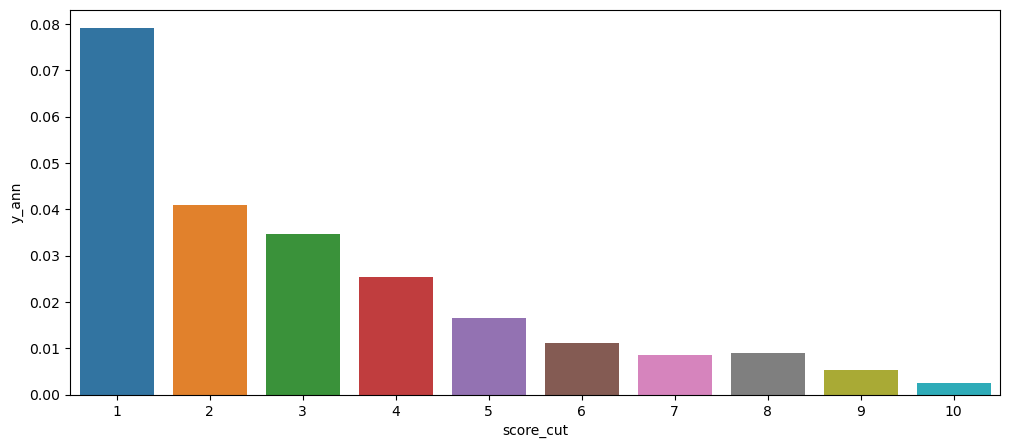

In [80]:
num_bins=10

binlabels=list(range(0, num_bins))

y_test_combined['score_cut']=pd.qcut(y_test_combined['composite_score'], q=num_bins, labels=binlabels)

fig=plt.figure(figsize=(12, 5))

y_test_combined=y_test_combined.groupby('score_cut')[['composite_score', 'y_ann']].mean().reset_index()
y_test_combined['score_cut']=y_test_combined['score_cut'].astype(int)
y_test_combined['score_cut']=num_bins-y_test_combined['score_cut']

sns.barplot(x=y_test_combined['score_cut'], y=y_test_combined['y_ann'])

Text(0, 0.5, 'Predicted/Actual')

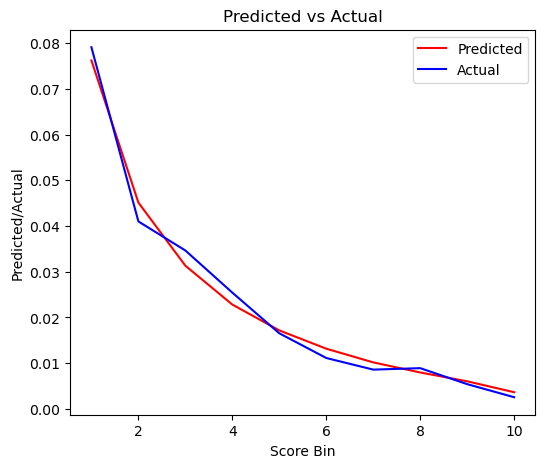

In [81]:
fig, ax=plt.subplots(1, 1, figsize=(6, 5))

ax.plot(y_test_combined['score_cut'], y_test_combined['composite_score'], label='Predicted', color='red')
ax.plot(y_test_combined['score_cut'], y_test_combined['y_ann'], label='Actual', color='blue')
ax.set_title('Predicted vs Actual')
ax.legend(loc='upper right')
ax.set_xlabel('Score Bin')
ax.set_ylabel('Predicted/Actual')